# Peak finder

Can one break a peak into several gaussian peaks usding pymc?

In [1]:
# http://onlinelibrary.wiley.com/doi/10.1002/2016JA022652/epdf
import datetime

import pymc
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import spacepy.plot as spp

This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/balarsen/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
print(datetime.datetime.now().isoformat())

2016-09-08T17:16:12.874856


## Simulate data

In [3]:
p1 = np.asarray([pymc.Normal('P1', 2, 1/0.04).value for v in range(1000)])
p2 = np.asarray([pymc.Normal('P2', 2.5, 1/0.04).value for v in range(1000)])
dat = np.hstack((p1,p2))

(array([  11.,   58.,  136.,  198.,  254.,  202.,   99.,   30.,   10.,    2.]),
 array([ 1.95413875,  2.08030681,  2.20647488,  2.33264294,  2.45881101,
         2.58497908,  2.71114714,  2.83731521,  2.96348328,  3.08965134,
         3.21581941]),
 <a list of 10 Patch objects>)

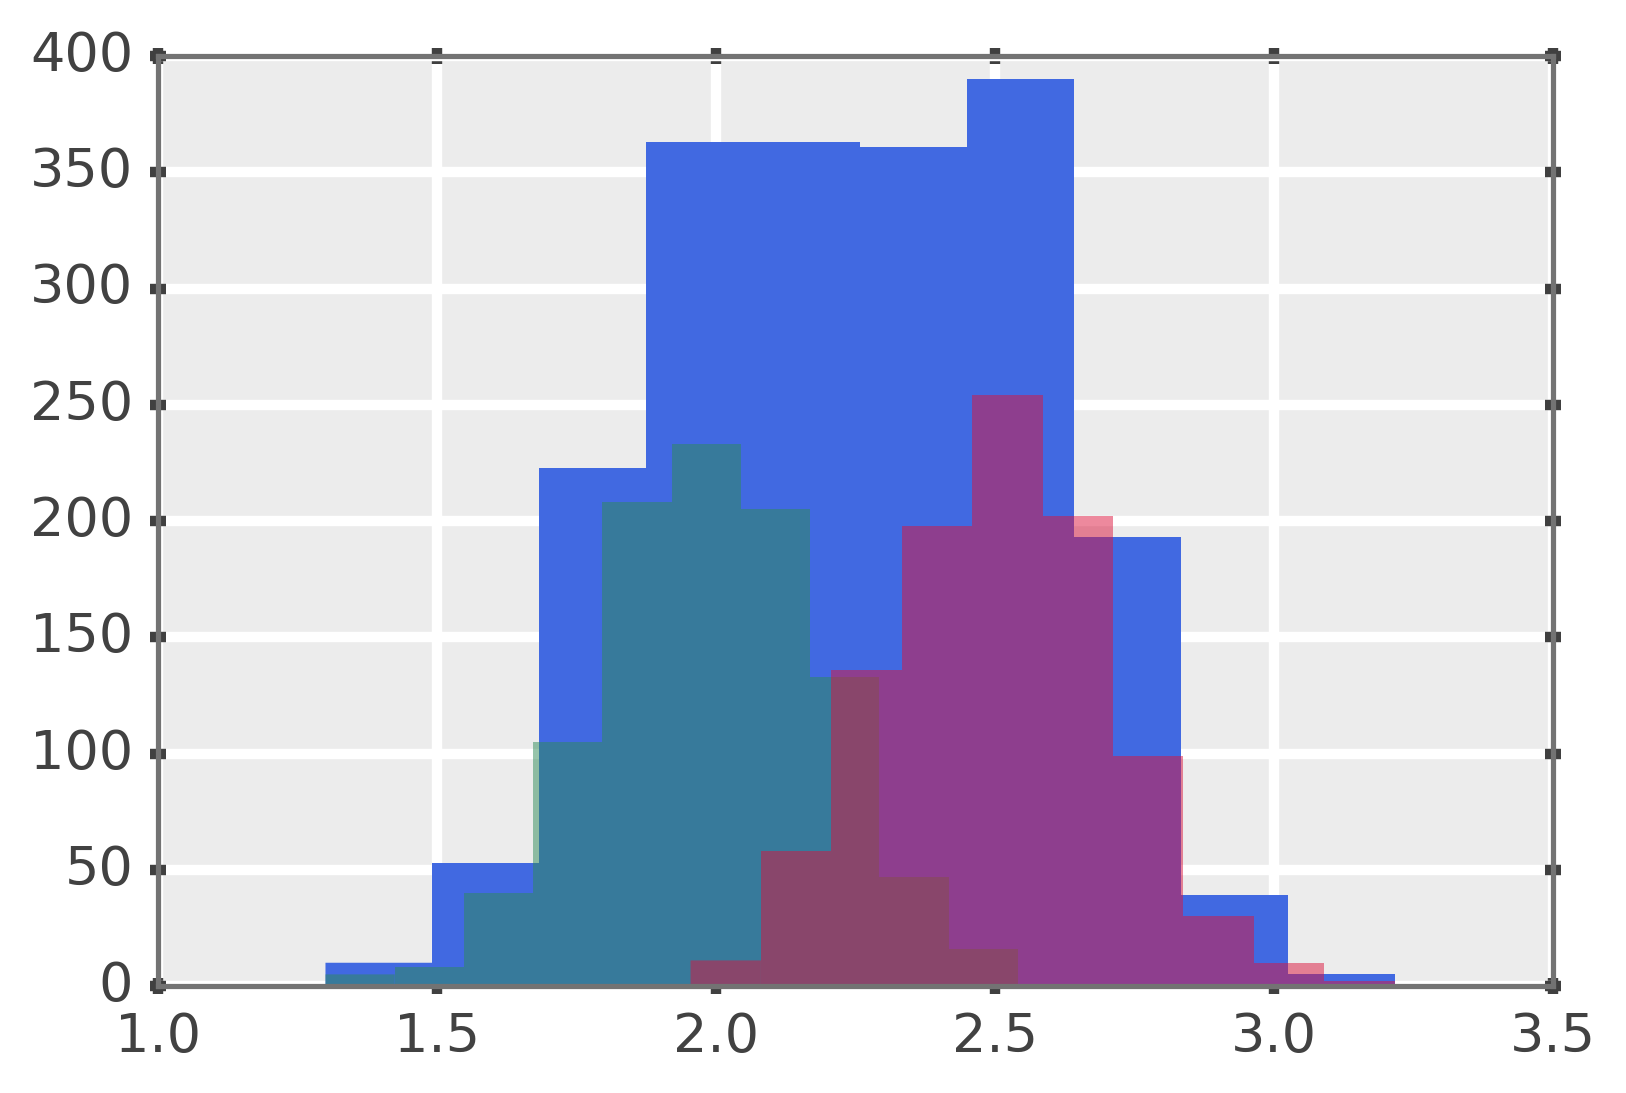

In [4]:
plt.hist(dat)
plt.hist(p1, alpha=0.5)
plt.hist(p2, alpha=0.5)


Now we know that the answer two overlayed gaussians. So model it that way and see what we can get.

In [5]:

cent = pymc.Container([pymc.Uniform('cent1', 1.5, 2.5), pymc.Uniform('cent2', cent1, 3.0)])





# # cent1 = pymc.Uniform('cent1', 1.5, 2.5)
# # cent2 = pymc.Uniform('cent2', cent1, 3.0)

# w = pymc.Container([pymc.Uniform('w1', 0, 30), pymc.Uniform('w2', 0, 30)])
# # w1 = pymc.Uniform('w1', 0, 30)
# # w2 = pymc.Uniform('w2', 0, 30)
# I = pymc.Container([pymc.Categorical('g1', [0.5]*len(cent)), pymc.Categorical('g2', [0.5]*len(cent))])

# p1 = pymc.Uniform('p1', 0, 1)
# p2 = 1-p1

# val = pymc.Container([pymc.Normal('val1', cent, w), pymc.Normal('val2', cent, w)])
# obsval = pymc.Normal('obs', val, w, observed=True, value=dat)


NameError: name 'cent1' is not defined

In [6]:
sigmas = pymc.Normal('sigmas', mu=2.25, tau=1000, size=2)
centers = pymc.Normal('centers', [1.8, 2.25], [20, 20], size=2)

alpha  = pymc.Beta('alpha', alpha=2, beta=3)
category = pymc.Container([pymc.Categorical("category%i" % i, [alpha, 1 - alpha]) 
                         for i in range(len(dat))])
observations = pymc.Container([pymc.Normal('samples_model%i' % i, 
                   mu=centers[category[i]], tau=1/(sigmas[category[i]]**2), 
                   value=dat[i], observed=True) for i in range(len(dat))])



In [7]:
model = pymc.Model([observations, category, alpha, sigmas, centers])


In [8]:
mcmc = pymc.MCMC(model)


In [9]:
# initialize in a good place to reduce the number of steps required
centers.value = [1.5, 3]


In [10]:
# set a custom proposal for centers, since the default is bad
mcmc.use_step_method(pymc.Metropolis, centers, proposal_sd=1.5/np.sqrt(len(dat)))


In [11]:
# set a custom proposal for category, since the default is bad
for i in range(len(dat)):
    mcmc.use_step_method(pymc.DiscreteMetropolis, category[i], proposal_distribution='Prior')


In [12]:
mcmc.sample(100)  # beware sampling takes much longer now
# check the acceptance rates
print(mcmc.step_method_dict[category[0]][0].ratio)
print(mcmc.step_method_dict[centers][0].ratio)
print(mcmc.step_method_dict[alpha][0].ratio)

 [-----------------100%-----------------] 100 of 100 complete in 37.4 sec0.93
0.53
0.05


Plotting centers_category1062


ValueError: Format "centers" is not supported.
Supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz.

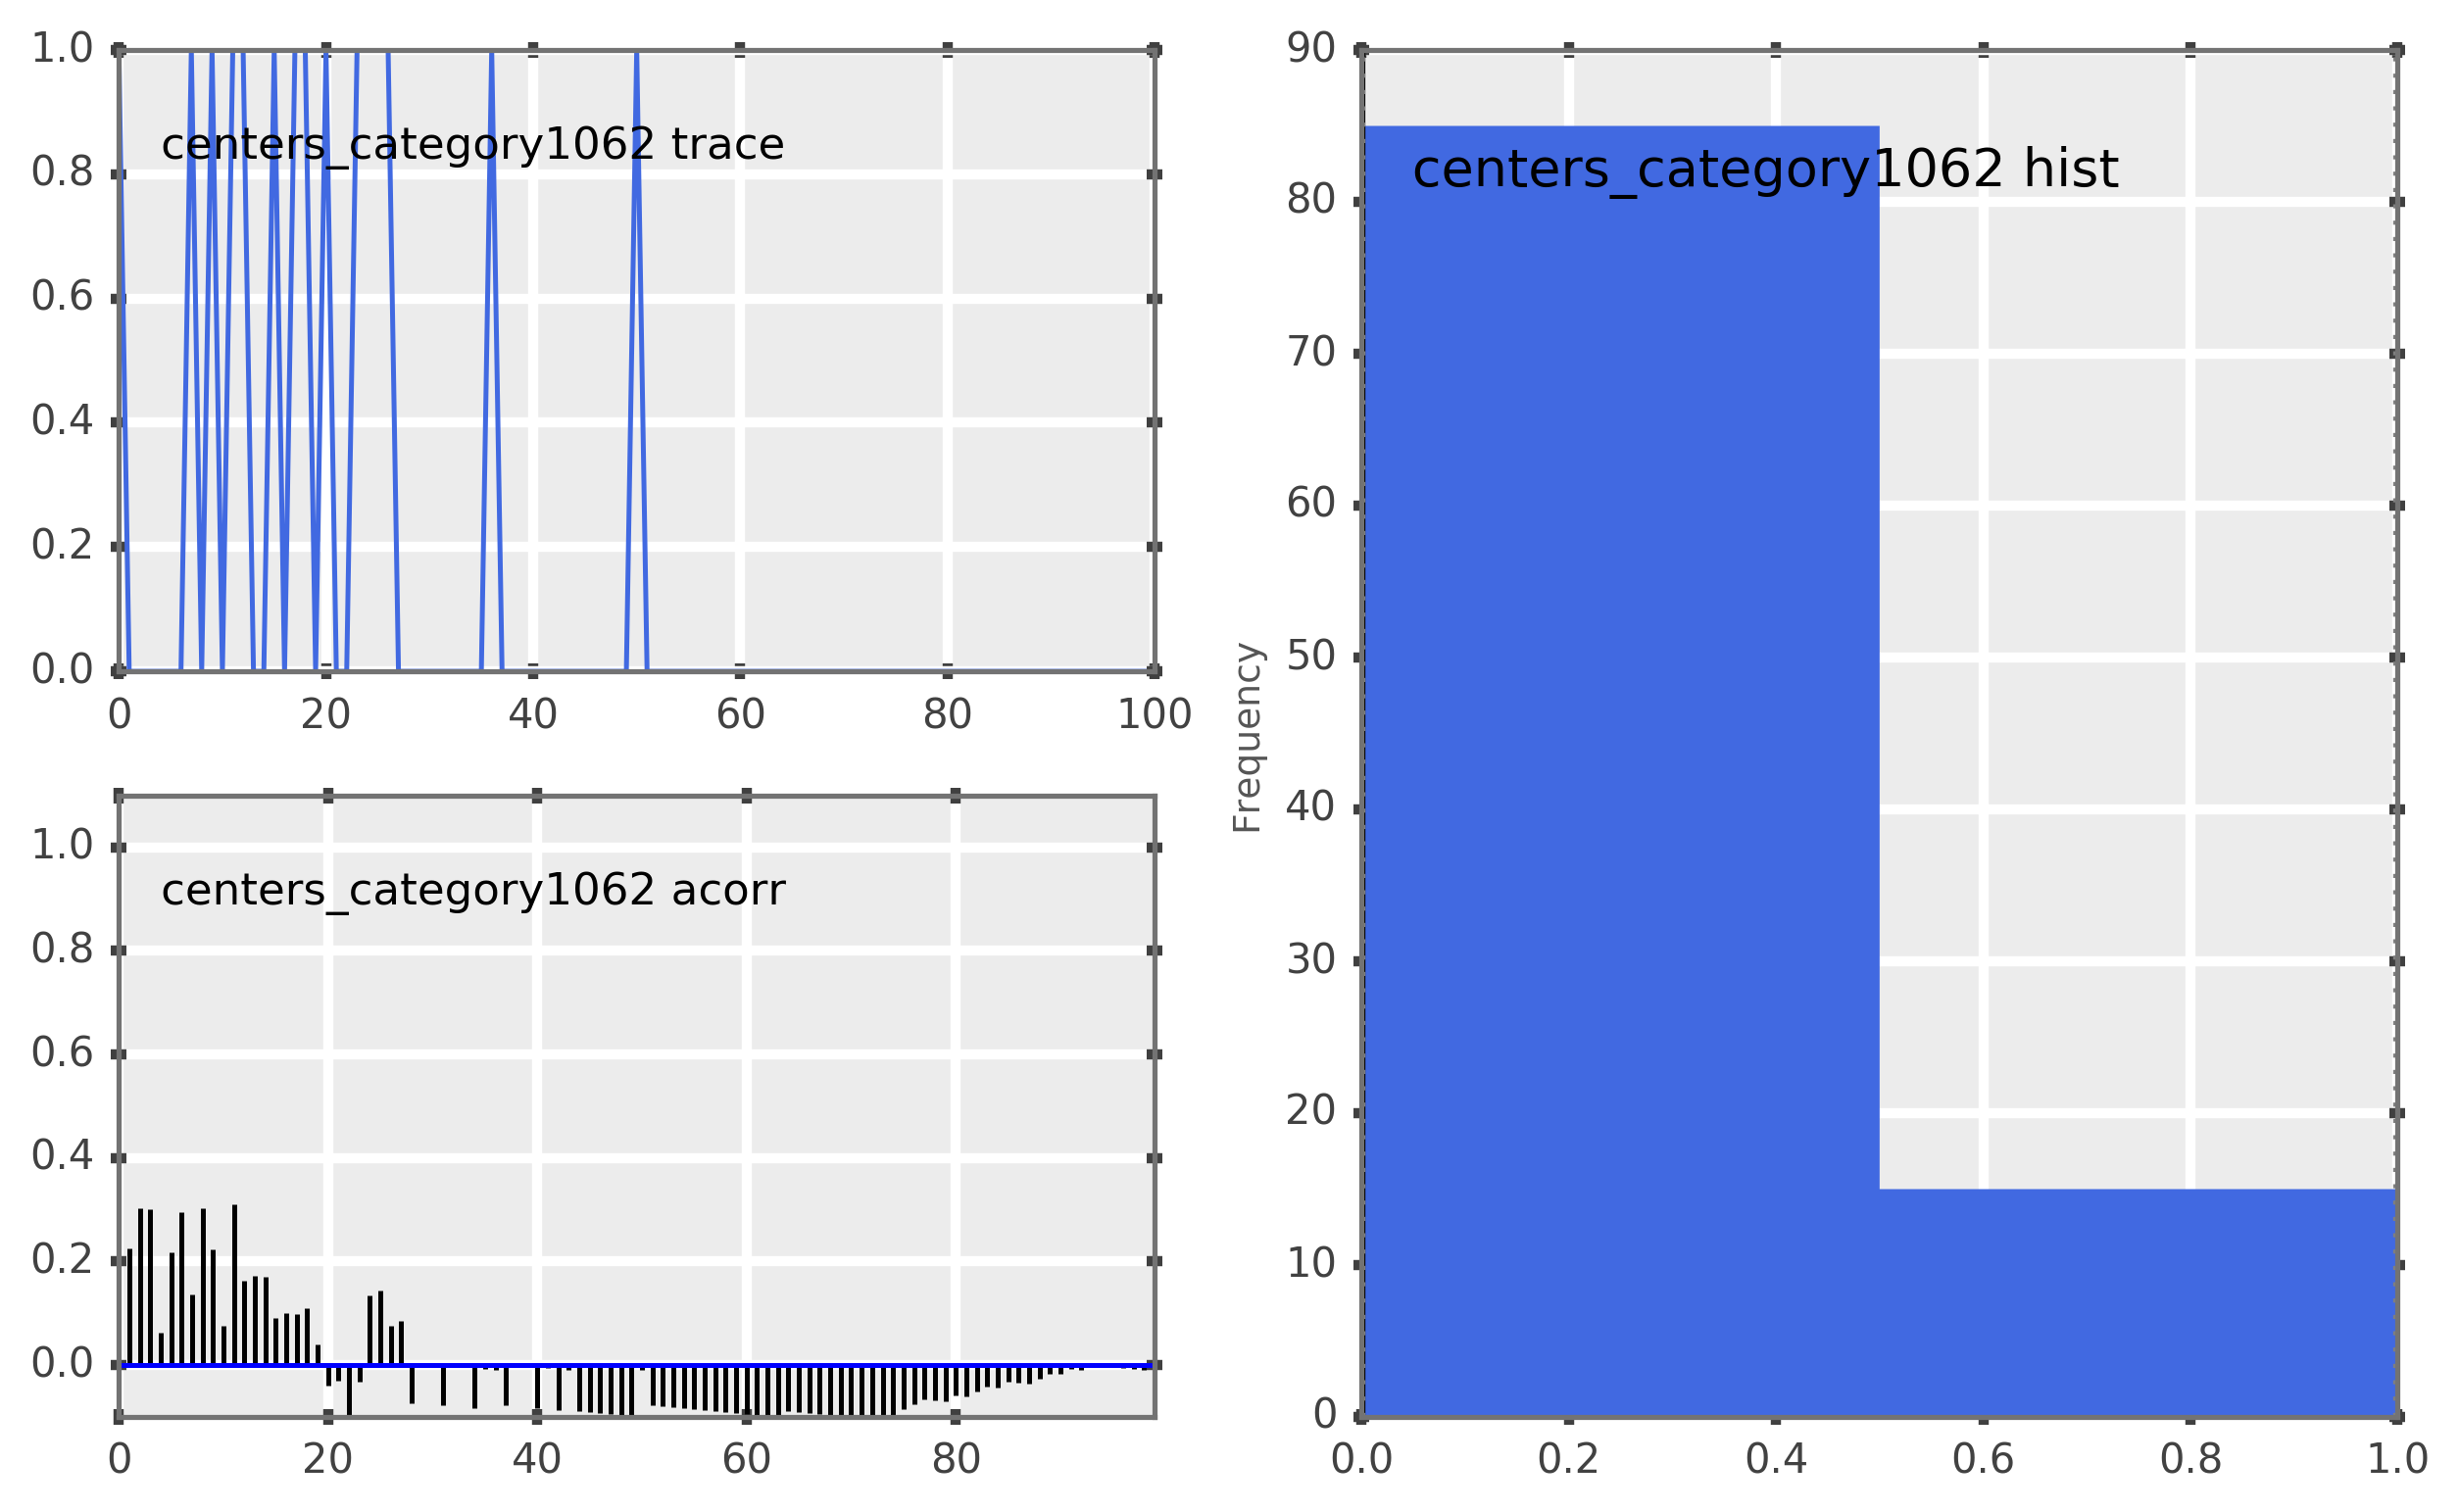

In [13]:
pymc.Matplot.plot(mcmc, centers)